### Imports

In [86]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Preprocessing and data splits

11867


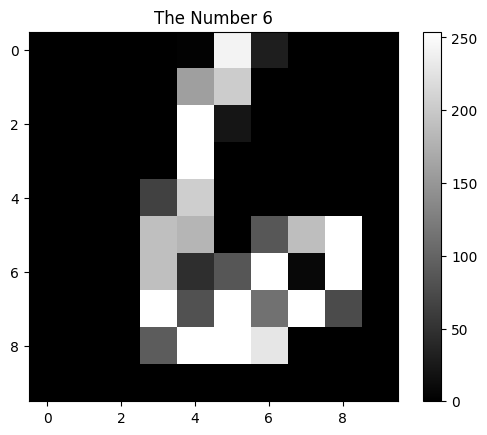

In [87]:


data = loadmat('data/MNISTmini.mat')
# print(data.keys())  # Shows variables in the file
# dataFrame  = pd.DataFrame(data)

colList = []
for i in range(len(data['train_fea1'][0])):
    colList.append(f"col{i+1}")

indexTrain = np.where(data['train_gnd1'] == 6)[0].tolist() + np.where(data['train_gnd1'] == 9)[0].tolist()
print(len(indexTrain))
dfTrain = pd.DataFrame(data['train_fea1'][indexTrain], columns=colList)
dfTrain['y'] = data['train_gnd1'][indexTrain]
dfTrain['y'] = dfTrain['y'].replace({6: 0, 9: 1})
dfTrain = dfTrain.reset_index(drop=True)

# Train and validation sets
x_train, x_val, y_train, y_val = train_test_split(dfTrain.drop(columns=['y']).reset_index(drop=True), dfTrain['y'], test_size=0.2, random_state=42)
indexTest = np.where(data['test_gnd1'] == 6)[0].tolist() + np.where(data['test_gnd1'] == 9)[0].tolist()
dfTest = pd.DataFrame(data['test_fea1'][indexTest], columns=colList)
dfTest['y'] = data['test_gnd1'][indexTest]
dfTest['y'] = dfTest['y'].replace({6: 0, 9: 1})
# Test sets
x_test = dfTest.drop(columns=['y'])
y_test = dfTest["y"]
 

img = x_train.iloc[0].to_numpy()
# Tranpose because the image is rotated
img = np.transpose(img.reshape(10,10))
# use grayscale
plt.title(f"The Number {6 if y_train.iloc[0] == 0 else 9}")
plt.imshow(img, cmap='gray')  
plt.colorbar()                
plt.show()

# Training

## Simple logistical Regresssion with l2 regularization

In [ ]:
logisticFit = LogisticRegression(solver="liblinear", penalty="l2", random_state=1)
logisticFit.fit(x_train, y_train)

pred_train = logisticFit.predict(x_train)
pred_val = logisticFit.predict(x_val)

pred_train_score = accuracy_score(y_train, pred_train)
pred_val_score = accuracy_score(y_val, pred_val)

print(f"Train Accuracy: {pred_train_score}")
print(f"Validation Accuracy: {pred_val_score}")


Train Accuracy: 1.0
Validation Accuracy: 0.9983150800336984


### The validation accuracy is pretty high so the test accuracy will be too, so we will add the validation set to the model.

In [89]:
X = dfTrain.drop(columns  =['y'])
Y = dfTrain['y']
logisticFit.fit(X,Y)
# now check test accuracy
pred_test = logisticFit.predict(x_test)
pred_test_score = accuracy_score(y_test, pred_test)
print(f"Test Accuracy: {pred_test_score}")


Test Accuracy: 0.9954245043213015


### The testing accuracy of is very close to 1 only off by about .0006, so this classifier is pretty good.

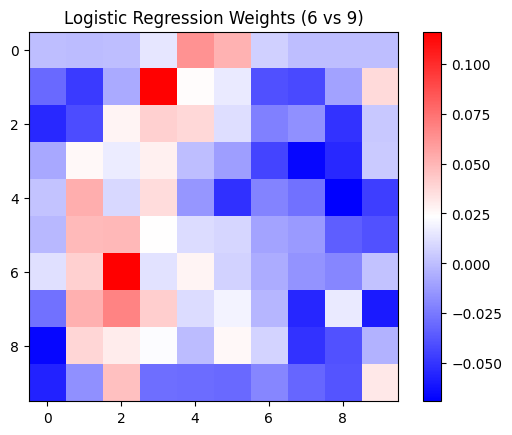

In [90]:
weights = logisticFit.coef_.reshape(10, 10)

plt.imshow(weights, cmap="bwr")  # blue = negative, red = positive
plt.colorbar()
plt.title("Logistic Regression Weights (6 vs 9)")
plt.show()

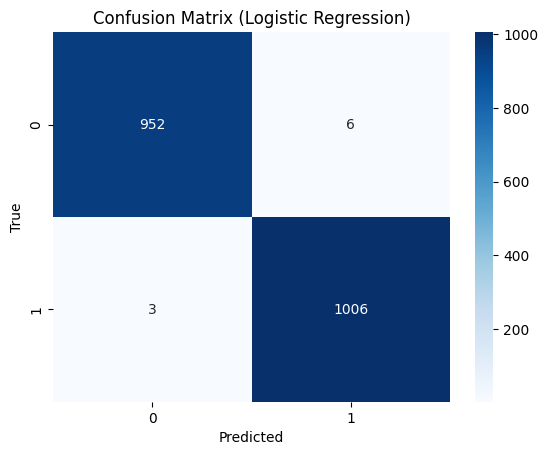

In [91]:
cm = confusion_matrix(y_test, pred_test)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()


## Logistical Regression with CV 

In [92]:
logSpace = np.logspace(-5,5, 100)
logisticCV = LogisticRegressionCV(Cs = logSpace, cv = 10, solver="liblinear", penalty="l2", random_state=1)
logisticCV.fit(x_train, y_train)


,Cs,array([1.0000...00000000e+05])
,fit_intercept,True
,cv,10
,dual,False
,penalty,'l2'
,scoring,None
,solver,'liblinear'
,tol,0.0001
,max_iter,100
,class_weight,None
,n_jobs,None


In [93]:
pred_train = logisticCV.predict(x_train)
pred_val = logisticCV.predict(x_val)

pred_train_score = accuracy_score(y_train, pred_train)
pred_val_score = accuracy_score(y_val, pred_val)
print(f"CV logistical Train score: {pred_train_score}")
print(f"CV logistical Validation score: {pred_val_score}")
print(f"The best hyper-parameter: {logisticCV.C_[0]}")


CV logistical Train score: 0.9976825028968713
CV logistical Validation score: 0.9983150800336984
The best hyper-parameter: 1.2618568830660211e-05


### The validation accuracy for this model is very high so we can juse refit the model with the training and validation set so we can have get the test accuracy.

In [94]:
# refit model
logisticCV.fit(X, Y)

,Cs,array([1.0000...00000000e+05])
,fit_intercept,True
,cv,10
,dual,False
,penalty,'l2'
,scoring,None
,solver,'liblinear'
,tol,0.0001
,max_iter,100
,class_weight,None
,n_jobs,None


In [95]:
pred_train = logisticCV.predict(x_train)
pred_val = logisticCV.predict(x_val)

pred_train_score = accuracy_score(y_train, pred_train)
pred_val_score = accuracy_score(y_val, pred_val)
print(f"CV logistical Train score: {pred_train_score}")
print(f"CV logistical Validation score: {pred_val_score}")

pred_test = logisticCV.predict(x_test)
pred_test_score = accuracy_score(y_test, pred_test)
print(f"CV logistical Test score: {pred_test_score}")
print(f"The best hyper-parameter: {logisticCV.C_[0]}")

CV logistical Train score: 0.9981038660065311
CV logistical Validation score: 0.9991575400168492
CV logistical Test score: 0.9959328927300457
The best hyper-parameter: 2.0092330025650458e-05


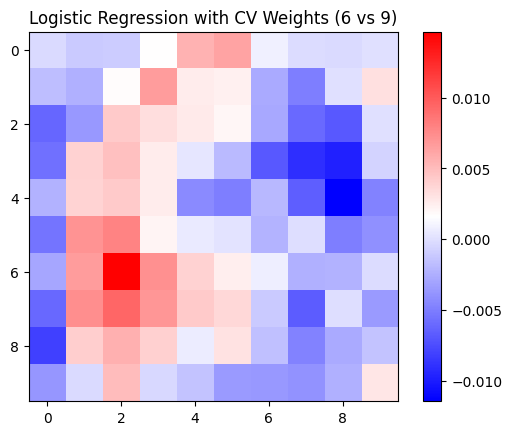

In [96]:
weights = logisticCV.coef_.reshape(10, 10)

plt.imshow(weights, cmap="bwr")  # blue = negative, red = positive
plt.colorbar()
plt.title("Logistic Regression with CV Weights (6 vs 9)")
plt.show()

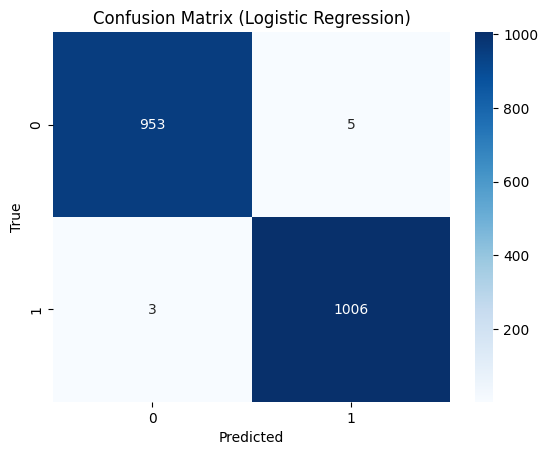

In [97]:
cm = confusion_matrix(y_test, pred_test)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()